In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm

import model, inference

from importlib import reload
reload(model)
reload(inference)

/storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /storage/coda1/p-awu36/0/cli726/.conda/envs/cli726/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


<module 'inference' from '/storage/coda1/p-awu36/0/cli726/vis/vae_mnist2/inference.py'>

In [2]:
method_list = np.array(['VI', 'CHIVI', 'VBIS', 'VIS', 'IWAE'])
seed_list = np.arange(5)
epoch_list = np.arange(20)
df_list = []

for method in method_list:
    for seed in seed_list:
        for epoch in epoch_list:
            try:
                df_temp = pd.read_csv(f'csv/{method}_{seed}_{epoch}.csv')
                df_temp['method'] = method
                df_temp['seed'] = seed
                df_temp['epoch'] = epoch
                df_list.append(df_temp)
            except:
                print(method)

df = pd.concat(df_list, ignore_index=True)

<AxesSubplot:xlabel='epoch', ylabel='marginal log-likelihood'>

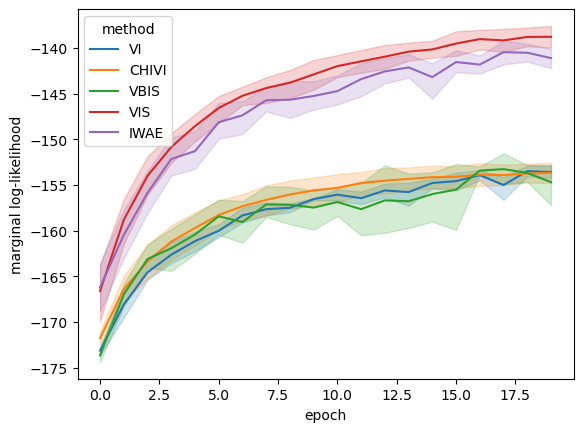

In [3]:
sns.lineplot(x='epoch', y='marginal log-likelihood', hue='method', data=df)

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3), constrained_layout=True, sharex=True)

ax = sns.barplot(x='method', y='marginal log-likelihood', data=df, ax=axs[0], order=method_list)
ax.set(xlabel=None)
# ax.get_legend().remove()
ax.tick_params(axis='x', rotation=60)
ax.set_ylim(-175, -135)

ax = sns.barplot(x='method', y='ELBO', data=df, ax=axs[1], order=method_list)
ax.set(xlabel=None)
# ax.get_legend().remove()
ax.tick_params(axis='x', rotation=60)

ax = sns.barplot(x='method', y='conditional log-likelihood', data=df, ax=axs[2], order=method_list)
ax.set(xlabel=None)
# ax.get_legend().remove()
ax.tick_params(axis='x', rotation=60)

ax = sns.barplot(x='method', y='time', data=df, ax=axs[3], order=method_list)
ax.set(xlabel=None)
# ax.get_legend().remove()
ax.tick_params(axis='x', rotation=60)
# ax.get_legend().remove()
# fig.savefig(f'{folder}_metric.pdf')

In [3]:
training_data = datasets.MNIST(
    root="../vae_mnist/data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="../vae_mnist/data",
    train=False,
    download=True,
    transform=ToTensor()
)

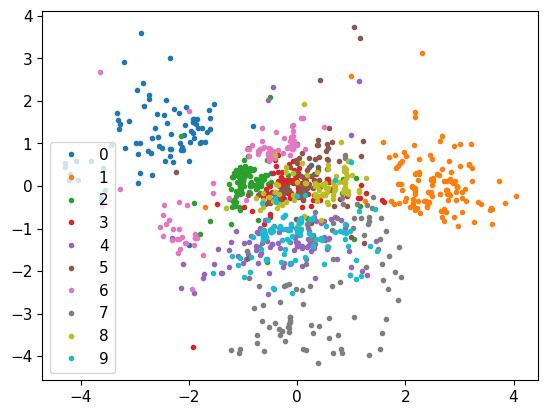

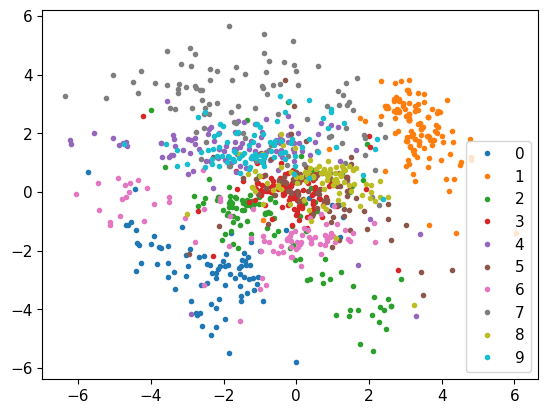

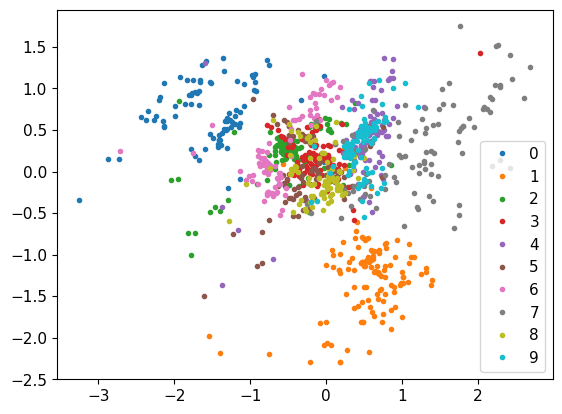

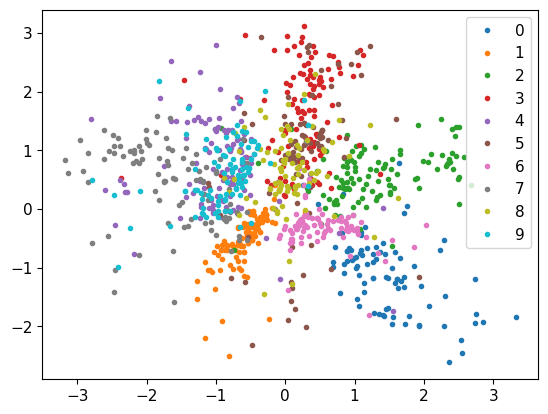

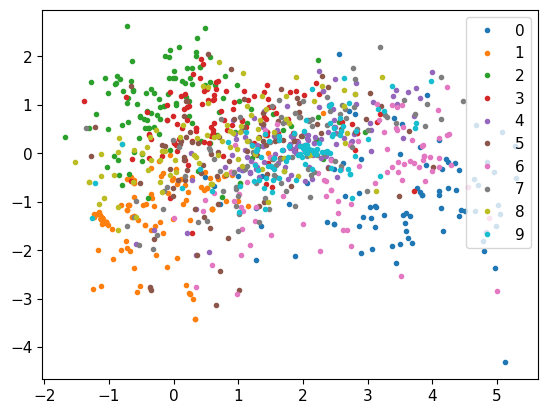

In [32]:
# fig, axs = plt.subplots(1, 5, figsize=(16, 4))
seed = 1

for method_idx, method in enumerate(method_list):
    plt.figure()
    vari_model = model.Encoder()
    vari_model.load_state_dict(torch.load(f'model/{method}_{seed}_vari.pt'))
    with torch.no_grad():
        mu, __ = vari_model(test_data.data[:1000].reshape((1000, -1)).to(torch.float32))
    for i in range(10):
        mu_i = mu[test_data.targets[:1000] == i]
        
        plt.plot(mu_i[:, 0], mu_i[:, 1], '.', label=i)
        plt.legend()

In [127]:
# def plot_manifold(inf_model, axs):
#     size = len(axs)
#     for i, z_1 in tqdm(enumerate(torch.linspace(-3, 3, size))):
#         for j, z_2 in enumerate(torch.linspace(-3, 3, size)):
#             z = torch.tensor([z_1, z_2])
#             x = 1 - inf_model.forward(z)
#             axs[i, j].imshow(x.reshape((28, 28)), cmap='gray')
#             axs[i, j].axis('off')

# method = 'VIS'
# with torch.no_grad():
#     inf_model.load_state_dict(torch.load(f'model/{method}_{seed}_inf.pt'))
#     fig, axs = plt.subplots(10, 10)
#     plot_manifold(inf_model, axs)

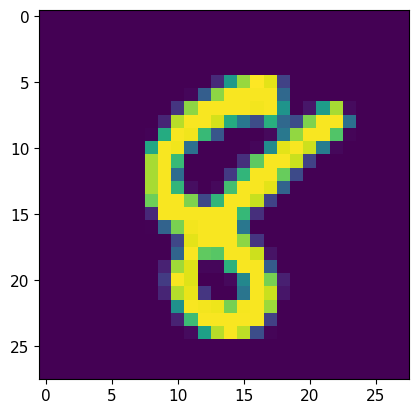

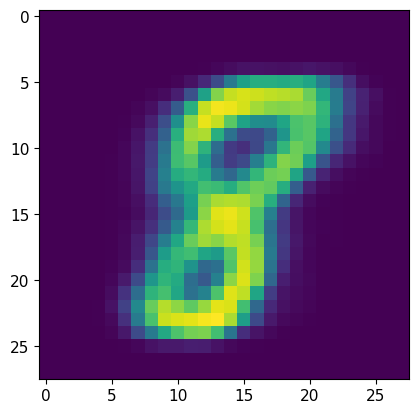

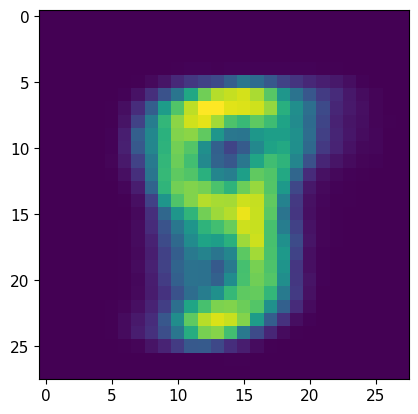

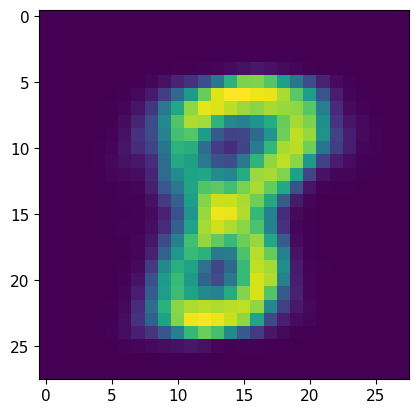

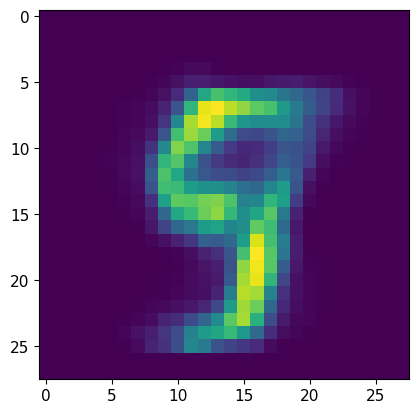

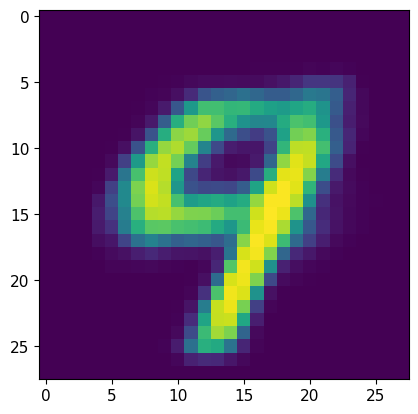

In [25]:
idx = 146
seed = 0

plt.figure()
plt.imshow(test_data[idx][0][0])

for method in method_list:
    vari_model = model.Encoder()
    vari_model.load_state_dict(torch.load(f'model/{method}_{seed}_vari.pt'))
    inf_model = model.Decoder()
    inf_model.load_state_dict(torch.load(f'model/{method}_{seed}_inf.pt'))
    with torch.no_grad():
        mu, __ = vari_model(test_data[idx][0].reshape(-1))
        x = inf_model(mu)
        plt.figure()
        plt.imshow(x.reshape((28, 28)))

100%|██████████| 6/6 [00:00<00:00,  9.62it/s]


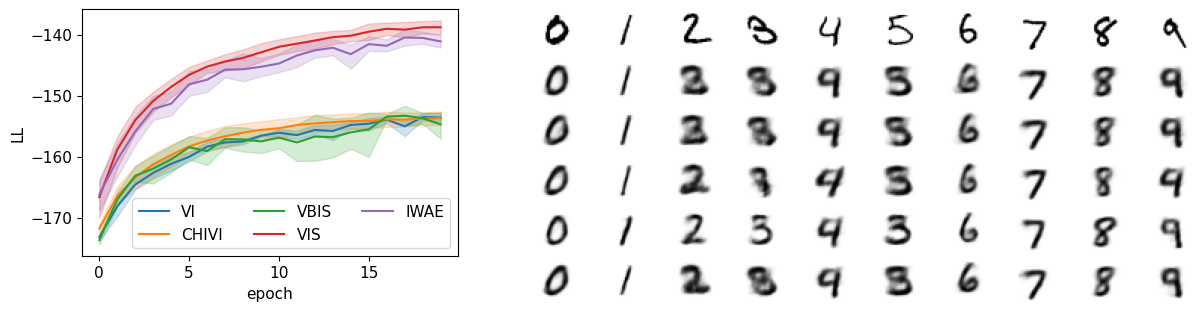

In [4]:
plt.rc('font', **{'size': 11})

seed = 1

fig = plt.figure(layout='constrained', figsize=(12, 3))
subfigs = fig.subfigures(1, 2, wspace=0.1, width_ratios=[1, 1.5])

ax = subfigs[0].subplots(1, 1)
sns.lineplot(x='epoch', y='marginal log-likelihood', hue='method', data=df, ax=ax)
ax.legend().set_title('')
ax.legend(ncol=3)
ax.set_ylabel('LL')

idx_list = np.array([3, 2, 1, 18, 4, 15, 21, 0, 146, 7])
axs = subfigs[1].subplots(6, 10)
with torch.no_grad():
    for i in tqdm(range(6)):
        if i == 0:
            for j in range(10):
                ax = axs[i, j]
                ax.imshow(1 - test_data[idx_list[j]][0][0], cmap='gray')
                ax.axis('off')
        else:
            method = method_list[i-1]
            inf_model = model.Decoder()
            vari_model = model.Encoder()
            if method != 'IWAE':
                inf_model.load_state_dict(torch.load(f'model/{method}_{seed}_inf.pt'))
                vari_model.load_state_dict(torch.load(f'model/{method}_{seed}_vari.pt'))
            else:
                inf_model.load_state_dict(torch.load(f'../vae_mnist/model/{method}_{seed}_inf.pt'))
                vari_model.load_state_dict(torch.load(f'../vae_mnist/model/{method}_{seed}_vari.pt'))
            for j in range(10):
                ax = axs[i, j]
                mu, __ = vari_model(test_data[idx_list[j]][0].reshape(-1))
                x = 1 - inf_model(mu).reshape((28, 28))
                ax.imshow(x, cmap='gray')
                ax.axis('off')

fig.savefig('vae.pdf', bbox_inches='tight', transparent=True)

20it [00:00, 27.69it/s]
20it [00:00, 62.63it/s]
20it [00:00, 61.27it/s]
20it [00:00, 41.79it/s]
20it [00:00, 40.96it/s]


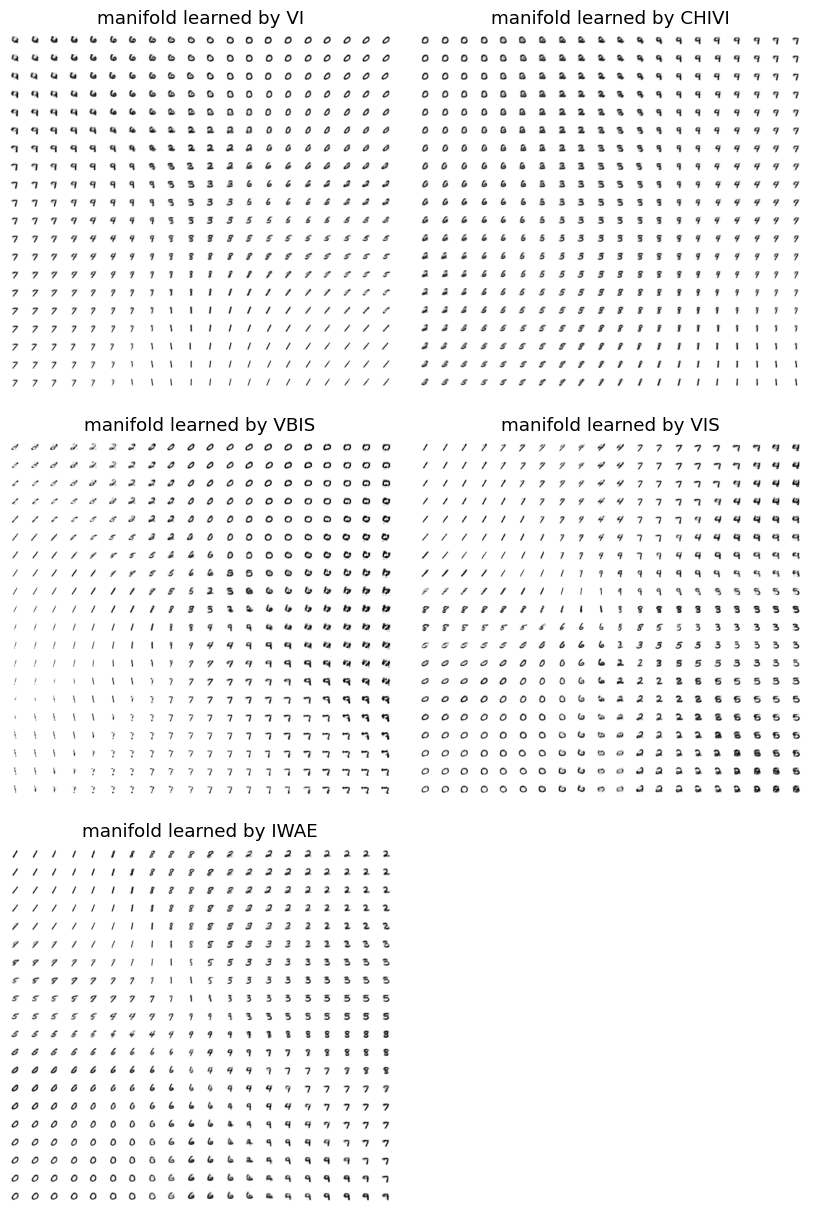

In [34]:
def plot_manifold(inf_model, axs):
    size = len(axs)
    for i, z_1 in tqdm(enumerate(torch.linspace(-3, 3, size))):
        for j, z_2 in enumerate(torch.linspace(-3, 3, size)):
            z = torch.tensor([z_1, z_2])
            x = 1 - inf_model.forward(z)
            axs[i, j].imshow(x.reshape((28, 28)), cmap='gray')
            axs[i, j].axis('off')

plt.rc('font', **{'size': 11})

seed = 1
size = 20

fig = plt.figure(layout='constrained', figsize=(8, 12))
subfigs = fig.subfigures(3, 2, hspace=0.05, wspace=0.05)

for i, method in enumerate(method_list):
    row, col = np.unravel_index(i, (3, 2))
    subfig = subfigs[row, col]
    inf_model = model.Decoder()
    with torch.no_grad():
        inf_model.load_state_dict(torch.load(f'model/{method}_{seed}_inf.pt'))
        axs = subfig.subplots(size, size)
        plot_manifold(inf_model, axs)
    subfig.suptitle(f'manifold learned by {method}')

fig.savefig('MNIST_manifold.pdf', bbox_inches='tight', transparent=True)